# 1. Image search using [SIFT](https://www.thepythoncode.com/article/sift-feature-extraction-using-opencv-in-python)

Let's think about information retrieval in the context of image search. How can we find images similar to a query in a fast way (faster than doing pair-wise comparison with all images in a database)? How can we identify same objects taken in slightly different contexts? 

One way to do this is to find special points of interest in every image, so called keypoints (or descriptors), which characterize the image and which are more or less invariant to scaling, orientation, illumination changes, and some other distortions. There are several algorithms available that identify such keypoints, and today we will focus on [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). 

Your task is to apply SIFT to a dataset of images and enable similar images search.

## Get dataset

We will use `Caltech 101` dataset, download it from [here](https://data.caltech.edu/records/mzrjq-6wc02). It consists of pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. The size of each image is roughly 300 x 200 pixels.

## SIFT example

Below is the example of SIFT keyponts extraction using `opencv`. [This](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html) is a dedicated tutorial, and [this](https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html) is another tutorial you may need to find matches between two images (use in your code `cv.drawMatches()` function to display keypoint matches).

In [ ]:
!pip install opencv-python opencv-contrib-python
# or use https://huggingface.co/datasets/will33am/Caltech101
!pip install datasets

In [ ]:
from datasets import load_dataset
load_dataset("will33am/Caltech101")
ds = load_dataset("will33am/Caltech101")

In [3]:
test, train = ds['test'], ds['train']

CLASSES = sorted(list(set([row['label'] for row in train])))
print(CLASSES)

strawberries = [row for row in train if row['label'] == 'strawberry']
wrenches = [row for row in train if row['label'] == 'wrench']
wrenches[17]

['accordion', 'airplanes', 'anchor', 'ant', 'background_google', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'faces', 'faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 's

{'id': 1379,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x142 at 0x7FEDC249FDF0>,
 'label': 'wrench'}

1st keypoint Location (2.97, 73.53)
1st keypoint Radius: 1.951104998588562;  angle:35.818634033203125


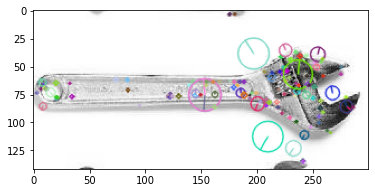

In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# img_dir = '../../101_ObjectCategories'
img = np.array(wrenches[17]['image'])
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# older versions of OpenCV
# sift = cv.xfeatures2d.SIFT_create()
sift = cv.SIFT_create()

kp = sift.detect(gray, None)
# use detectAndCompute(...) to get descriptors themselves

print(f"1st keypoint Location ({kp[0].pt[0]:.2f}, {kp[0].pt[1]:.2f})")
print(f"1st keypoint Radius: {kp[0].size};  angle:{kp[0].angle}")
img=cv.drawKeypoints(gray, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

### Discussion

**Q**: Discuss what you see here. What is the meaning of circle diameter? Of the angle?

## Index of keypoints

Let's suppose we've found image descriptors. How do we find similar images, having this information? In our case the descriptors are 128-dinensional vectors per keypoint, and there can be hundreds of such points. To enable fast search of similar images, you will index descriptors of all images using some data structure for approximate nearest neighbors search, such as Navigable Small World or Annoy. Then, for a (new) query image you will generate descriptors, and for each of these descriptors you will find its nearest neighbors (using Euclidean or Cosine distance, which you prefer). Finally, you will sort potential similar images (retrieved from neighbor descriptors) by frequency with which they appear in the nearest neighbors (more matches - higher the rank).

### Build an index

Read all images, saving category information. For every image generate SIFT descriptors and index them.

In [5]:
# read all images and add their descriptors to index
import glob
import numpy as np
from tqdm import tqdm

def generate_sift_descriptors(img):    

    #TODO return keypoints and their descriptors
    gray = cv.cvtColor(np.array(img), cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create() 
    kp, des = sift.detectAndCompute(gray, None)
    
    return kp, des
        

def get_top_descriptors(kp, des, top_k):
    response_sort_indices = [i for (v, i) in sorted(((v, i) for (i, v) in enumerate(kp)), 
                                       key=lambda k: k[0].response, reverse=True)]        
    top_des = np.take(des, response_sort_indices[:top_k], axis=0)
    return top_des

In [6]:
# test
kp, des = generate_sift_descriptors(wrenches[3]['image'])
print("Keypoints:", len(kp), len(des))
print("Center:", kp[4].pt)
print("Vector:\n", des[4].reshape(16, -1))

Keypoints: 23 23
Center: (68.9178466796875, 139.43971252441406)
Vector:
 [[  0.   0.   0.   0.  56. 162.  20.   0.]
 [ 94.   1.   0.   0.   7.  63.  16.  27.]
 [162.   9.   0.   0.   0.   0.   3.  89.]
 [ 30.   2.   0.   0.   0.   0.   7.  30.]
 [  0.   0.   0.   0.  36. 162.  39.   0.]
 [ 77.   2.   0.   0.  27. 162.  45.  14.]
 [162.  21.   0.   0.   2.  19.   7.  19.]
 [ 55.   7.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   2.  74.  16.   0.]
 [ 12.   0.   0.   0.  19. 162.  54.  15.]
 [162.   3.   0.   0.   1.  56.  66. 102.]
 [ 43.   2.   0.   0.   0.   0.   0.  13.]
 [  0.   0.   0.   0.   1.   7.   1.   0.]
 [  0.   0.   0.   0.   0.  41.  22.   2.]
 [  5.   0.   0.   0.   0.  13.  42.  36.]
 [  3.   0.   0.   0.   0.   0.   2.  12.]]


In [7]:
vectors = []
dataset = train
categories = list(set([row['label'] for row in dataset]))
cat_lookup = dict((c, i) for i, c in enumerate(categories))

for i, row in enumerate(tqdm(train)):
    idn, img, label = row['id'], row['image'], row['label'] 
    keypoints, descriptors = generate_sift_descriptors(img)
    vectors.append(get_top_descriptors(keypoints, descriptors, 32))

100%|██████████| 3060/3060 [00:41<00:00, 73.58it/s]


In [8]:
vectors[10].shape

(32, 128)

In [9]:
%%time
from annoy import AnnoyIndex

annoy = AnnoyIndex(128, 'euclidean')
for i, vectors32 in enumerate(vectors):
    for vec in vectors32:
        annoy.add_item(i, vec)

annoy.build(100, n_jobs=-1)

CPU times: user 1.29 s, sys: 9.82 ms, total: 1.3 s
Wall time: 981 ms


True

### Implement search function

Implement a function which returns `k` neighbours (names) sorted for a given image name.

In [10]:
from collections import Counter

def classifier(image, index, k):
    keypoints, descriptors = generate_sift_descriptors(image)
    vecs = get_top_descriptors(keypoints, descriptors, 32)
    
    # TODO
    # return the list of ordered pairs,
    # similarity first
    counter = Counter()
    for vec in vecs:
        nns = index.get_nns_by_vector(vec, 100)
        for idx in nns:
            counter[dataset[idx]['label']] += 1
    
    return counter.most_common(k)

# finds query image in the result, as it is indexed
print("STRAWBERRY")
result = classifier(strawberries[22]['image'], annoy, 10)
print(*result, sep='\n')
print()
print("WRENCH")
result = classifier(wrenches[11]['image'], annoy, 10)
print(*result, sep='\n')

STRAWBERRY
('strawberry', 75)
('accordion', 59)
('crab', 52)
('pagoda', 51)
('nautilus', 51)
('ibis', 48)
('menorah', 47)
('dolphin', 46)
('buddha', 45)
('lotus', 44)

WRENCH
('brontosaurus', 67)
('rhino', 58)
('rooster', 56)
('stegosaurus', 52)
('elephant', 50)
('pagoda', 49)
('water_lilly', 49)
('faces_easy', 49)
('panda', 49)
('barrel', 48)


**Q**: Before going further, discuss, why SIFT is unsuitable for searching similar things. What is the application area? Is it reliable in this area, and to which extent?


# 2. Deep classifiers and Embeddings

Based on:
- https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
- https://github.com/christiansafka/img2vec
- https://github.com/ultralytics/yolov5

### Obtain a single label for the image

In [ ]:
!pip install torch torchvision imageio

In [ ]:
import torch
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

In [13]:
from imageio import imread

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Ferry_in_Istanbul_01.JPG/1200px-Ferry_in_Istanbul_01.JPG'
im = imread(url)
results = model(im)
pandas_detections_df = results.pandas().xyxy[0]
pandas_detections_df

,xmin,ymin,xmax,ymax,confidence,class,name
0,231.662933,438.303741,967.604065,679.622925,0.799427,8,boat
1,361.097229,377.688568,398.801453,408.567474,0.670532,8,boat
2,0.000000,272.096954,162.217133,414.139282,0.579390,8,boat
3,654.251953,347.974030,693.994751,379.135345,0.452190,8,boat
4,425.258209,366.256195,453.129822,384.371582,0.363021,8,boat
5,0.000000,343.417908,143.792633,411.330292,0.298748,8,boat
6,350.790344,508.589844,371.002045,538.935242,0.260130,0,person
7,805.094482,457.490021,819.061768,481.860962,0.256485,0,person


In [14]:
results.print()

image 1/1: 800x1200 2 persons, 6 boats
Speed: 5.5ms pre-process, 384.7ms inference, 1.2ms NMS per image at shape (1, 3, 448, 640)


### Compute the classes for the dataset. 

pagoda	person


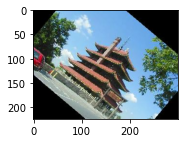


scissors	scissors


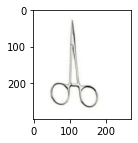


wild_cat	None


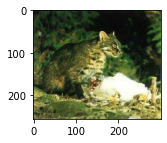


mandolin	None


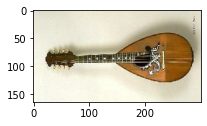


lamp	bottle


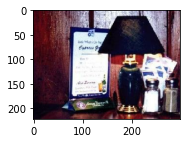


hedgehog	None


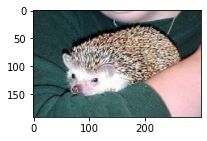


leopards	None


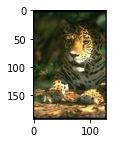


yin_yang	person


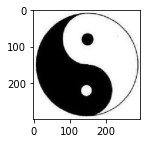


bass	None


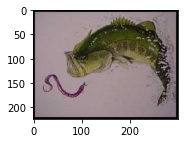


lobster	None


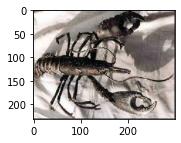


ewer	None


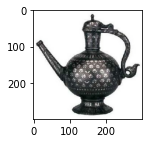


bonsai	bottle


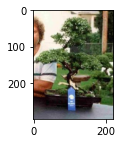


crocodile_head	None


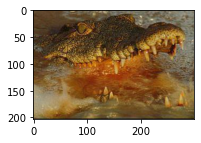


sunflower	None


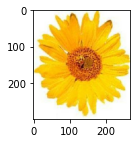


garfield	teddy bear


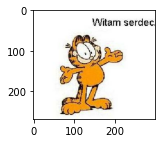

In [15]:
%matplotlib inline

for i, row in enumerate(dataset):
    if i % 213 != 0: continue
    results = model(row['image'])
    tag = results.pandas().xyxy[0]['name']
    tag = tag[0] if len(tag) else None
    cat = row['label']
    print(f"{cat}\t{tag}")
    plt.figure(figsize=(3,2))
    plt.imshow(np.array(row['image']))
    plt.show()
    print()

**Discuss:** 
- Look at the results. 
- Can we use this for retrieval in the same way as we used SIFT features? 
- What if the labels are different from original? What if there are multiple or no labels?

## Vector embedding for image.

In [16]:
!pip install img2vec_pytorch Pillow

In [17]:
from img2vec_pytorch import Img2Vec
from PIL import Image

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Ferry_in_Istanbul_01.JPG/1200px-Ferry_in_Istanbul_01.JPG'
img = imread(url)

# Initialize Img2Vec
img2vec = Img2Vec(cuda=False)
# some magic with broken Pillow.
vector = img2vec.get_vec([Image.fromarray(img)]).reshape(-1)
vector.shape

(512,)

In [18]:
embedding_vectors = []

def get_vectors(images):
    vecs = []
    img2vec = Img2Vec(cuda=False)
    for image in tqdm(images):
        # some more magic with broken pillow
        vecs += [img2vec.get_vec([Image.fromarray(np.array(image))]).reshape(-1)]
    # TODO
    # return the np.array with the shape of (files x 512)
    return np.vstack(vecs)

sorted_dataset = map(int, np.argsort([row['label'] for row in dataset]))
images_sample = [dataset[row]['image'] for i, row in enumerate(sorted_dataset) if i < 200]
embedding_vectors = get_vectors(images_sample)

100%|██████████| 200/200 [00:20<00:00,  9.89it/s]


In [19]:
embedding_vectors.shape

(200, 512)

In [20]:
from sklearn.metrics import pairwise_distances
d = pairwise_distances(embedding_vectors, metric='cosine')

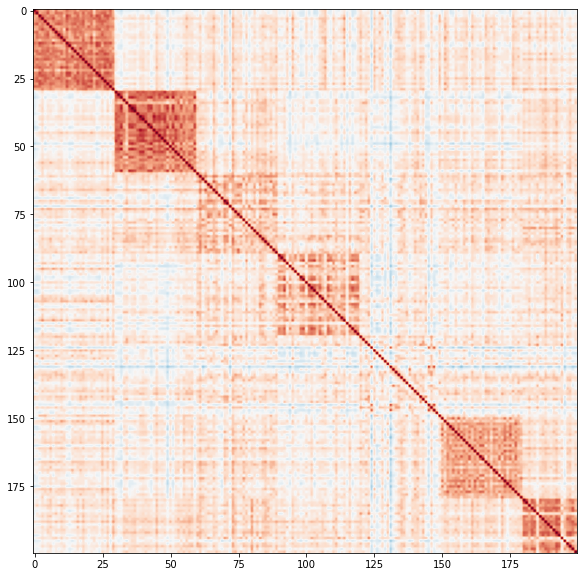

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(d, cmap='RdBu', vmin=0, vmax=1)
plt.show()